# Decapodes

When specifying a physical system, we use differential equations. Decapodes is a language for representing systems of equations that works with UWDs
to implement multiphysics composition. This example shows you how to use the DecaExpr language for specifying physics equations.
We only look at ordinary differential equations here, but you can think of these as partial differential equations on the zero dimensional manifold (the point).

In [1]:
using ..SyntacticModels
using ..SyntacticModels.ASKEMDecapodes
using ..SyntacticModels.AMR

using MLStyle
using JSON3
using Catlab
using ACSets
using ACSets.JSONACSets
using Decapodes
using Test

Build the heder object describing the model.

In [2]:
h = AMR.Header("harmonic_oscillator",
  "modelreps.io/DecaExpr",
  "A Simple Harmonic Oscillator as a Diagrammatic Equation",
  "DecaExpr",
  "v1.0")

SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0")

The easiest way to write down a DecaExpr is in our DSL and calling the parser.

In [3]:
dexpr = Decapodes.parse_decapode(quote
  X::Form0{Point}
  V::Form0{Point}

  k::Constant{Point}

  ∂ₜ(X) == V
  ∂ₜ(V) == -1*k*(X)
end
)

Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))])

Bundle the DecaExpr with the header metadata.

In [4]:
mexpr = ASKEMDecaExpr(h, dexpr)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))]))

Convert a the DecaExpr to a SummationDecapode which is the
combinatorial representation. The converter lives in Decapodes/src/language.jl.

In [5]:
d = Decapodes.SummationDecapode(mexpr.model)

Decapodes.SummationDecapode{Any, Any, Symbol} {Var:6, TVar:2, Op1:2, Op2:2, Σ:0, Summand:0, Type:0, Operator:0, Name:0}
┌─────┬──────────┬────────┐
│ Var │     type │   name │
├─────┼──────────┼────────┤
│   1 │    Form0 │      X │
│   2 │    Form0 │      V │
│   3 │ Constant │      k │
│   4 │    infer │ mult_1 │
│   5 │    infer │      V̇ │
│   6 │  Literal │     -1 │
└─────┴──────────┴────────┘
┌──────┬──────┐
│ TVar │ incl │
├──────┼──────┤
│    1 │    2 │
│    2 │    5 │
└──────┴──────┘
┌─────┬─────┬─────┬─────┐
│ Op1 │ src │ tgt │ op1 │
├─────┼─────┼─────┼─────┤
│   1 │   1 │   2 │  ∂ₜ │
│   2 │   2 │   5 │  ∂ₜ │
└─────┴─────┴─────┴─────┘
┌─────┬───────┬───────┬─────┬─────┐
│ Op2 │ proj1 │ proj2 │ res │ op2 │
├─────┼───────┼───────┼─────┼─────┤
│   1 │     6 │     3 │   4 │   * │
│   2 │     4 │     1 │   5 │   * │
└─────┴───────┴───────┴─────┴─────┘

To visualize the Decapode as a compute graph, you can use Graphviz

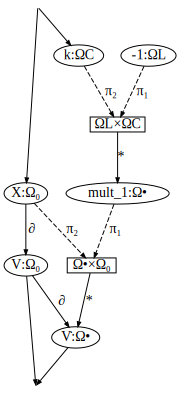

In [6]:
to_graphviz(d)

We want different metadata for this representation.
The Summation prefix just means that this decapodes have
specialized support for the handling of summation.
The summation operator happens in physics so often,
that you want to bake in some specialized handling to the data structure.

In [7]:
h = AMR.Header("harmonic_oscillator",
  "modelreps.io/SummationDecapode",
  "A Simple Harmonic Oscillator as a Diagrammatic Equation",
  "SummationDecapode",
  "v1.0")
mpode = ASKEMDecapode(h, d)

SyntacticModels.ASKEMDecapodes.ASKEMDecapode(SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/SummationDecapode", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "SummationDecapode", "v1.0"), Decapodes.SummationDecapode{Any, Any, Symbol}:
  Var = 1:6
  TVar = 1:2
  Op1 = 1:2
  Op2 = 1:2
  Σ = 1:0
  Summand = 1:0
  Type = 1:0
  Operator = 1:0
  Name = 1:0
  src : Op1 → Var = [1, 2]
  tgt : Op1 → Var = [2, 5]
  proj1 : Op2 → Var = [6, 4]
  proj2 : Op2 → Var = [3, 1]
  res : Op2 → Var = [4, 5]
  incl : TVar → Var = [2, 5]
  summand : Summand → Var = Int64[]
  summation : Summand → Σ = Int64[]
  sum : Σ → Var = Int64[]
  op1 : Op1 → Operator = [:∂ₜ, :∂ₜ]
  op2 : Op2 → Operator = [:*, :*]
  type : Var → Type = [:Form0, :Form0, :Constant, :infer, :infer, :Literal]
  name : Var → Name = [:X, :V, :k, :mult_1, :V̇, Symbol("-1")])

The syntactic representation can be serialized as JSON.
The resulting structure is like a parse tree of the syntactic
representation of the DecaExpr

In [8]:
JSON3.pretty(mexpr)

{
    "header": {
        "description": "A Simple Harmonic Oscillator as a Diagrammatic Equation",
        "name": "harmonic_oscillator",
        "_type": "Header",
        "model_version": "v1.0",
        "schema": "modelreps.io/DecaExpr",
        "schema_name": "DecaExpr"
    },
    "_type": "ASKEMDecaExpr",
    "model": {
        "context": [
            {
                "dim": "Form0",
                "var": {
                    "name": "X",
                    "_type": "Var"
                },
                "space": "Point",
                "_type": "Judgement"
            },
            {
                "dim": "Form0",
                "var": {
                    "name": "V",
                    "_type": "Var"
                },
                "space": "Point",
                "_type": "Judgement"
            },
            {
                "dim": "Constant",
                "var": {
                    "name": "k",
                    "_type": "Var"
                },
  

We could also use the JSON serialization built into Catlab
to serialize the resulting combinatorial representation

In [9]:
JSON3.pretty(generate_json_acset(mpode.model))

{
    "Var": [
        {
            "_id": 1,
            "type": "Form0",
            "name": "X"
        },
        {
            "_id": 2,
            "type": "Form0",
            "name": "V"
        },
        {
            "_id": 3,
            "type": "Constant",
            "name": "k"
        },
        {
            "_id": 4,
            "type": "infer",
            "name": "mult_1"
        },
        {
            "_id": 5,
            "type": "infer",
            "name": "V̇"
        },
        {
            "_id": 6,
            "type": "Literal",
            "name": "-1"
        }
    ],
    "TVar": [
        {
            "_id": 1,
            "incl": 2
        },
        {
            "_id": 2,
            "incl": 5
        }
    ],
    "Op1": [
        {
            "_id": 1,
            "src": 1,
            "tgt": 2,
            "op1": "∂ₜ"
        },
        {
            "_id": 2,
            "src": 2,
            "tgt": 5,
            "op1": "∂ₜ"
        }
    ],
